In [1]:
import torch

# Check the PyTorch version
print(f"PyTorch Version: {torch.__version__}")

# Check if PyTorch can use your GPU (if you installed a CUDA version)
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.7.1+cu128
CUDA Available: True
GPU: NVIDIA GeForce GTX 1650 Ti


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import time

class MPS(nn.Module):
    """Matrix Product State implementation with automatic differentiation support"""
    
    def __init__(self, L: int, d: int, chi: int, dtype=torch.float64):
        """
        Initialize MPS
        Args:
            L: Number of sites
            d: Physical dimension (2 for spin-1/2)
            chi: Bond dimension
            dtype: Data type for tensors
        """
        super().__init__()
        self.L = L
        self.d = d
        self.chi = chi
        self.dtype = dtype
        
        # Initialize MPS tensors as parameters
        self.tensors = nn.ParameterList()
        
        # Left boundary tensor: shape (d, chi)
        self.tensors.append(nn.Parameter(
            torch.randn(d, chi, dtype=dtype) * 0.1
        ))
        
        # Bulk tensors: shape (chi, d, chi)
        for i in range(1, L-1):
            self.tensors.append(nn.Parameter(
                torch.randn(chi, d, chi, dtype=dtype) * 0.1
            ))
        
        # Right boundary tensor: shape (chi, d)
        self.tensors.append(nn.Parameter(
            torch.randn(chi, d, dtype=dtype) * 0.1
        ))
        
        # Initialize with random product state
        self.initialize_product_state()
    
    def initialize_product_state(self):
        """Initialize as a product state in +x direction"""
        with torch.no_grad():
            # |+⟩ = (|0⟩ + |1⟩)/√2
            state = torch.tensor([1.0, 1.0], dtype=self.dtype) / np.sqrt(2)
            
            # Left boundary
            self.tensors[0].data = state.unsqueeze(1).repeat(1, self.chi)
            
            # Bulk tensors - only first bond dimension matters for product state
            for i in range(1, self.L-1):
                self.tensors[i].data.zero_()
                self.tensors[i].data[0, :, 0] = state
            
            # Right boundary
            self.tensors[-1].data = state.unsqueeze(0).repeat(self.chi, 1)
    
    def normalize(self):
        """Normalize the MPS"""
        with torch.no_grad():
            # Compute norm
            norm = self.compute_norm()
            # Normalize the first tensor
            self.tensors[0].data /= norm**(1/self.L)
    
    def compute_norm(self):
        """Compute the norm of the MPS"""
        # Contract ⟨ψ|ψ⟩ = Tr(ρ) where ρ is the density matrix
        # Start from the left
        if self.L == 1:
            return torch.sqrt(torch.einsum('ia,ia->', self.tensors[0], self.tensors[0]))
        
        # Left boundary contraction
        result = torch.einsum('ia,ib->ab', self.tensors[0], self.tensors[0])
        
        # Bulk contractions
        for i in range(1, self.L-1):
            result = torch.einsum('ab,aic,bid->cd', result, self.tensors[i], self.tensors[i])
        
        # Right boundary contraction
        result = torch.einsum('ab,ai,bi->', result, self.tensors[-1], self.tensors[-1])
        
        return torch.sqrt(result)
    
    def forward(self):
        """Forward pass - returns the norm for gradient computation"""
        return self.compute_norm()

class TFIM_Energy:
    """Transverse Field Ising Model energy calculator"""
    
    def __init__(self, L: int, J: float = 1.0, h: float = 1.0):
        """
        Initialize TFIM Hamiltonian
        Args:
            L: Number of sites
            J: Ising coupling strength
            h: Transverse field strength
        """
        self.L = L
        self.J = J
        self.h = h
        
        # Pauli matrices
        self.sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.float64)
        self.sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.float64)
        self.I = torch.eye(2, dtype=torch.float64)
    
    def compute_energy(self, mps: MPS) -> torch.Tensor:
        """Compute energy expectation value ⟨ψ|H|ψ⟩"""
        energy = 0.0
        
        # Ising interaction terms: -J Σᵢ σᵢᶻ σᵢ₊₁ᶻ
        for i in range(self.L - 1):
            energy += -self.J * self.compute_two_site_expectation(mps, i, i+1, 
                                                                  self.sigma_z, self.sigma_z)
        
        # Transverse field terms: -h Σᵢ σᵢˣ
        for i in range(self.L):
            energy += -self.h * self.compute_one_site_expectation(mps, i, self.sigma_x)
        
        return energy
    
    def compute_one_site_expectation(self, mps: MPS, site: int, operator: torch.Tensor) -> torch.Tensor:
        """Compute single-site expectation value"""
        # Build left environment
        if site == 0:
            left_env = None
        else:
            left_env = torch.einsum('ia,ib->ab', mps.tensors[0], mps.tensors[0])
            for i in range(1, site):
                left_env = torch.einsum('ab,aic,bid->cd', left_env, mps.tensors[i], mps.tensors[i])
        
        # Build right environment
        if site == mps.L - 1:
            right_env = None
        else:
            right_env = torch.einsum('ai,bi->ab', mps.tensors[-1], mps.tensors[-1])
            for i in range(mps.L - 2, site, -1):
                right_env = torch.einsum('cd,aic,bid->ab', right_env, mps.tensors[i], mps.tensors[i])
        
        # Contract with operator
        if site == 0:
            # Left boundary: tensor shape is (d, chi)
            tensor_with_op = torch.einsum('ij,jb->ib', operator, mps.tensors[0])
            tensor_conj = mps.tensors[0]
            
            if right_env is None:
                # Single site case
                result = torch.einsum('ia,ib->', tensor_with_op, tensor_conj)
            else:
                result = torch.einsum('ia,ib,ab->', tensor_with_op, tensor_conj, right_env)
                
        elif site == mps.L - 1:
            # Right boundary: tensor shape is (chi, d)
            tensor_with_op = torch.einsum('ai,ij->aj', mps.tensors[site], operator)
            tensor_conj = mps.tensors[site]
            
            if left_env is None:
                # Single site case
                result = torch.einsum('ai,aj->', tensor_with_op, tensor_conj)
            else:
                result = torch.einsum('ab,bi,bj->', left_env, tensor_with_op, tensor_conj)
                
        else:
            # Bulk tensor: shape is (chi, d, chi)
            tensor_with_op = torch.einsum('aic,ij->ajc', mps.tensors[site], operator)
            tensor_conj = mps.tensors[site]
            
            if left_env is None and right_env is None:
                # Single site case
                result = torch.einsum('aic,ajc->', tensor_with_op, tensor_conj)
            elif left_env is None:
                result = torch.einsum('aic,ajc,cc->', tensor_with_op, tensor_conj, right_env)
            elif right_env is None:
                result = torch.einsum('ab,bic,bjc->', left_env, tensor_with_op, tensor_conj)
            else:
                result = torch.einsum('ab,bic,bjc,cd->', left_env, tensor_with_op, tensor_conj, right_env)
        
        return result
    
    def compute_two_site_expectation(self, mps: MPS, site1: int, site2: int, 
                                   op1: torch.Tensor, op2: torch.Tensor) -> torch.Tensor:
        """Compute two-site expectation value (for adjacent sites)"""
        assert site2 == site1 + 1, "Only adjacent sites supported"
        
        # Build left environment
        if site1 == 0:
            left_env = None
        else:
            left_env = torch.einsum('ia,ib->ab', mps.tensors[0], mps.tensors[0])
            for i in range(1, site1):
                left_env = torch.einsum('ab,aic,bid->cd', left_env, mps.tensors[i], mps.tensors[i])
        
        # Build right environment
        if site2 == mps.L - 1:
            right_env = None
        else:
            right_env = torch.einsum('ai,bi->ab', mps.tensors[-1], mps.tensors[-1])
            for i in range(mps.L - 2, site2, -1):
                right_env = torch.einsum('cd,aic,bid->ab', right_env, mps.tensors[i], mps.tensors[i])
        
        # Handle different boundary cases
        if site1 == 0 and site2 == 1:
            # Left boundary case: tensor[0] is (d, chi), tensor[1] is (chi, d, chi)
            tensor1_with_op = torch.einsum('ij,jb->ib', op1, mps.tensors[0])
            tensor2_with_op = torch.einsum('aic,ij->ajc', mps.tensors[1], op2)
            
            tensor1_conj = mps.tensors[0]
            tensor2_conj = mps.tensors[1]
            
            # Contract: left_op * left_conj * right_op * right_conj * right_env
            intermediate = torch.einsum('ia,ib,bjc,bid->acd', tensor1_with_op, tensor1_conj, 
                                      tensor2_with_op, tensor2_conj)
            
            if right_env is None:
                result = torch.einsum('acc->', intermediate)
            else:
                result = torch.einsum('acd,cd->', intermediate, right_env)
                
        elif site2 == mps.L - 1:
            # Right boundary case: tensor[site1] is (chi, d, chi), tensor[site2] is (chi, d)
            tensor1_with_op = torch.einsum('aic,ij->ajc', mps.tensors[site1], op1)
            tensor2_with_op = torch.einsum('ci,ij->cj', mps.tensors[site2], op2)
            
            tensor1_conj = mps.tensors[site1]
            tensor2_conj = mps.tensors[site2]
            
            # Contract: left_env * left_op * left_conj * right_op * right_conj
            intermediate = torch.einsum('bic,bjc,ci,cj->b', tensor1_with_op, tensor1_conj,
                                      tensor2_with_op, tensor2_conj)
            
            if left_env is None:
                result = torch.einsum('b->', intermediate)
            else:
                result = torch.einsum('ab,b->', left_env, intermediate)
                
        else:
            # Bulk case: both tensors are (chi, d, chi)
            tensor1_with_op = torch.einsum('aic,ij->ajc', mps.tensors[site1], op1)
            tensor2_with_op = torch.einsum('cid,ij->cjd', mps.tensors[site2], op2)
            
            tensor1_conj = mps.tensors[site1]
            tensor2_conj = mps.tensors[site2]
            
            # Contract all pieces
            intermediate = torch.einsum('bic,bjc,cjd,ckd->bd', tensor1_with_op, tensor1_conj,
                                      tensor2_with_op, tensor2_conj)
            
            if left_env is None and right_env is None:
                result = torch.einsum('bb->', intermediate)
            elif left_env is None:
                result = torch.einsum('bd,bd->', intermediate, right_env)
            elif right_env is None:
                result = torch.einsum('ab,ab->', left_env, intermediate)
            else:
                result = torch.einsum('ab,bd,cd->', left_env, intermediate, right_env)
        
        return result

def gradient_descent_optimization(L: int, chi: int, J: float = 1.0, h: float = 1.0,
                                lr: float = 0.01, max_iter: int = 1000, 
                                tolerance: float = 1e-8) -> Tuple[MPS, List[float]]:
    """
    Perform gradient descent optimization of MPS
    """
    # Initialize MPS
    mps = MPS(L, d=2, chi=chi)
    
    # Initialize energy calculator
    tfim = TFIM_Energy(L, J, h)
    
    # Optimizer
    optimizer = optim.Adam(mps.parameters(), lr=lr)
    
    # Store energy history
    energies = []
    
    print(f"Starting gradient descent optimization...")
    print(f"System size: {L}, Bond dimension: {chi}")
    print(f"J = {J}, h = {h}")
    
    start_time = time.time()
    
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # Normalize MPS
        mps.normalize()
        
        # Compute energy
        energy = tfim.compute_energy(mps)
        energies.append(energy.item())
        
        # Backward pass
        energy.backward()
        
        # Update parameters
        optimizer.step()
        
        # Check convergence
        if iteration > 0 and abs(energies[-1] - energies[-2]) < tolerance:
            print(f"Converged after {iteration} iterations")
            break
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Energy = {energy.item():.8f}")
    
    end_time = time.time()
    print(f"Optimization completed in {end_time - start_time:.2f} seconds")
    print(f"Final energy: {energies[-1]:.8f}")
    
    return mps, energies

def exact_ground_state_energy(L: int, J: float = 1.0, h: float = 1.0) -> float:
    """
    Compute exact ground state energy using full diagonalization (for small systems)
    """
    if L > 12:
        print("Warning: Exact diagonalization only feasible for small systems")
        return None
    
    # Build Hamiltonian matrix
    dim = 2**L
    H = torch.zeros(dim, dim, dtype=torch.float64)
    
    # Pauli matrices
    sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.float64)
    sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.float64)
    I = torch.eye(2, dtype=torch.float64)
    
    # Ising terms
    for i in range(L-1):
        op = torch.tensor(1.0, dtype=torch.float64)
        for j in range(L):
            if j == i:
                op = torch.kron(op, sigma_z)
            elif j == i+1:
                op = torch.kron(op, sigma_z)
            else:
                op = torch.kron(op, I)
        H -= J * op
    
    # Transverse field terms
    for i in range(L):
        op = torch.tensor(1.0, dtype=torch.float64)
        for j in range(L):
            if j == i:
                op = torch.kron(op, sigma_x)
            else:
                op = torch.kron(op, I)
        H -= h * op
    
    # Diagonalize
    eigenvalues = torch.linalg.eigvals(H)
    return torch.min(eigenvalues.real).item()

Starting gradient descent optimization...
System size: 8, Bond dimension: 4
J = 1.0, h = 1.5
Iteration 0: Energy = -41.50000000
Iteration 100: Energy = -58195201839.82489014
Iteration 200: Energy = -12059196043340304.00000000
Iteration 300: Energy = -15936859674063663104.00000000
Iteration 400: Energy = -2059412448781798735872.00000000
Optimization completed in 24.76 seconds
Final energy: -71121456679032614551552.00000000

Comparison:
MPS energy: -71121456679032614551552.00000000
Exact energy: -13.19140495
Error: 71121456679032614551552.00000000


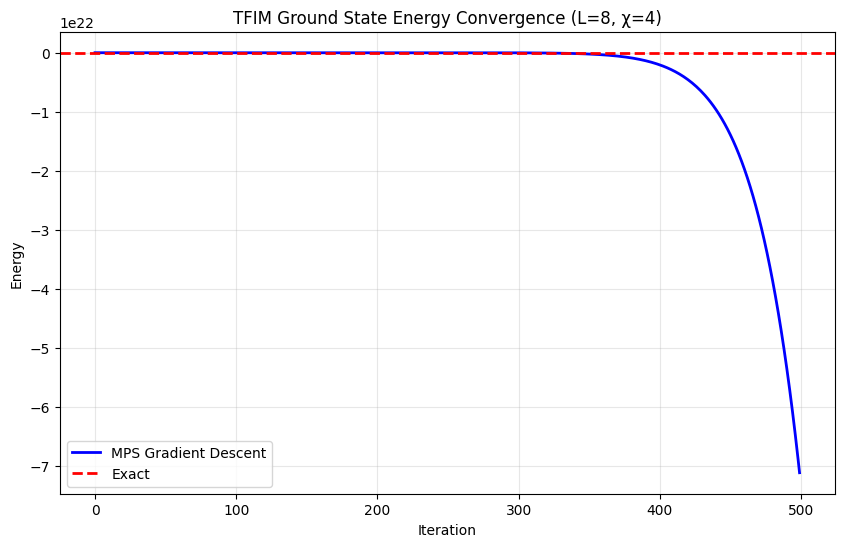

In [9]:
if __name__ == "__main__":
    # Test parameters
    L = 8  # Small system for testing
    chi = 4  # Bond dimension
    J = 1.0
    h = 1.5
    
    # Run gradient descent optimization
    mps, energies = gradient_descent_optimization(L, chi, J, h, lr=0.01, max_iter=500)
    
    # Compare with exact result
    exact_energy = exact_ground_state_energy(L, J, h)
    if exact_energy is not None:
        print(f"\nComparison:")
        print(f"MPS energy: {energies[-1]:.8f}")
        print(f"Exact energy: {exact_energy:.8f}")
        print(f"Error: {abs(energies[-1] - exact_energy):.8f}")
    
    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(energies, 'b-', linewidth=2, label='MPS Gradient Descent')
    if exact_energy is not None:
        plt.axhline(y=exact_energy, color='r', linestyle='--', linewidth=2, label='Exact')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title(f'TFIM Ground State Energy Convergence (L={L}, χ={chi})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()